**Dependency

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path
import numpy as np
import cv2
import pandas as pd


DATASET Overview: 986 face images and 986 non face images

In [ ]:
SEED = 42

DATASET_ROOT = "/home/teaching/Documents/assignment/assignment_1/dataset/face-nonface"
FACE_IMAGES_PATH = os.path.join(DATASET_ROOT, "face")
NON_FACE_IMAGES_PATH = os.path.join(DATASET_ROOT, "non-face")

OUTPUT_ROOT = "/home/teaching/Documents/assignment/assignment_1/face-nonface_modified"

os.makedirs(OUTPUT_ROOT, exist_ok=True)

def split_files(file_list, seed):
    """Split files into train, validation and test sets"""
    if len(file_list) == 0:
        return [], [], []
    train_files, val_test_files = train_test_split(file_list, test_size=0.3, random_state=seed, shuffle=True)
    val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=seed, shuffle=True)
    return train_files, val_files, test_files

def create_directory_structure(output_root):
    """Create the required directory structure"""
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_root, "face", split), exist_ok=True)
        os.makedirs(os.path.join(output_root, "non-face", split), exist_ok=True)

create_directory_structure(OUTPUT_ROOT)

print("Processing face images...")
face_image_files = [f for f in os.listdir(FACE_IMAGES_PATH) 
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
train_face, val_face, test_face = split_files(face_image_files, SEED)

for file in train_face:
    shutil.copy2(os.path.join(FACE_IMAGES_PATH, file), 
                os.path.join(OUTPUT_ROOT, "face", "train", file))
for file in val_face:
    shutil.copy2(os.path.join(FACE_IMAGES_PATH, file), 
                os.path.join(OUTPUT_ROOT, "face", "val", file))
for file in test_face:
    shutil.copy2(os.path.join(FACE_IMAGES_PATH, file), 
                os.path.join(OUTPUT_ROOT, "face", "test", file))

print("\nProcessing non-face images...")
non_face_files = []

for root, _, files in os.walk(NON_FACE_IMAGES_PATH):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            full_path = os.path.join(root, file)
            rel_path = os.path.relpath(full_path, NON_FACE_IMAGES_PATH)
            non_face_files.append(rel_path)

print(f"Found {len(non_face_files)} non-face images")

train_non_face, val_non_face, test_non_face = split_files(non_face_files, SEED)

for file in train_non_face:
    src = os.path.join(NON_FACE_IMAGES_PATH, file)
    dst = os.path.join(OUTPUT_ROOT, "non-face", "train", os.path.basename(file))
    shutil.copy2(src, dst)

for file in val_non_face:
    src = os.path.join(NON_FACE_IMAGES_PATH, file)
    dst = os.path.join(OUTPUT_ROOT, "non-face", "val", os.path.basename(file))
    shutil.copy2(src, dst)

for file in test_non_face:
    src = os.path.join(NON_FACE_IMAGES_PATH, file)
    dst = os.path.join(OUTPUT_ROOT, "non-face", "test", os.path.basename(file))
    shutil.copy2(src, dst)

print("\nFace Images:")
print(f"Training: {len(train_face)}")
print(f"Validation: {len(val_face)}")
print(f"Test: {len(test_face)}\n")

print("\nNon-Face Images:")
print(f"Training: {len(train_non_face)}")
print(f"Validation: {len(val_non_face)}")
print(f"Test: {len(test_non_face)}\n")

def count_images(path):
    return len([f for f in Path(path).rglob('*') if f.is_file() and 
               f.suffix.lower() in ('.jpg', '.jpeg', '.png')])

print("\nVerifying copied files:")
for split in ['train', 'val', 'test']:
    face_count = count_images(os.path.join(OUTPUT_ROOT, "face", split))
    non_face_count = count_images(os.path.join(OUTPUT_ROOT, "non-face", split))
    print(f"{split}:")
    print(f"  Face images: {face_count}")
    print(f"  Non-face images: {non_face_count}")

print("\nDataset splitting completed successfully!")

Processing face images...

Processing non-face images...
Found 986 non-face images

Face Images:
Training: 690
Validation: 148
Test: 148


Non-Face Images:
Training: 690
Validation: 148
Test: 148


Verifying copied files:
train:
  Face images: 690
  Non-face images: 690
val:
  Face images: 148
  Non-face images: 148
test:
  Face images: 148
  Non-face images: 148

Dataset splitting completed successfully!


##LBP feature extraction into .csv file and last coloumn of csv files is level which indicate face or non-face

In [ ]:
from skimage.feature import local_binary_pattern

def get_lbp_features(image_path):
    """Extract LBP features from an image."""
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = n_points + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype('float') / (hist.sum() + 1e-7)
    return hist

base_dir = "/home/teaching/Documents/assignment/assignment_1/face-nonface_modified"
classes = ['face', 'non-face']
splits = ['train', 'val', 'test']

for split in splits:
    features_list = []
    labels = []
    
    for label in classes:
        folder = Path(os.path.join(base_dir, label, split))
        for img_path in folder.glob('*.jpg'):
            try:
                features = get_lbp_features(img_path)
                features_list.append(features)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    if not features_list:
        print(f"No images found for {split}")
        continue

    feature_columns = [f'lbp_{i}' for i in range(len(features_list[0]))]
    df = pd.DataFrame(features_list, columns=feature_columns)
    df['label'] = labels
    output_path = f'lbp_{split}.csv'
    df.to_csv(output_path, index=False)
    print(f"Saved {output_path} with {len(df)} samples.")


Saved lbp_train.csv with 1380 samples.
Saved lbp_val.csv with 296 samples.
Saved lbp_test.csv with 296 samples.


Best KNN: k=1, metric=chebyshev, Test Accuracy=0.9426
Best One-vs-Rest SVM: kernel=rbf, C=10, Test Accuracy=0.9696


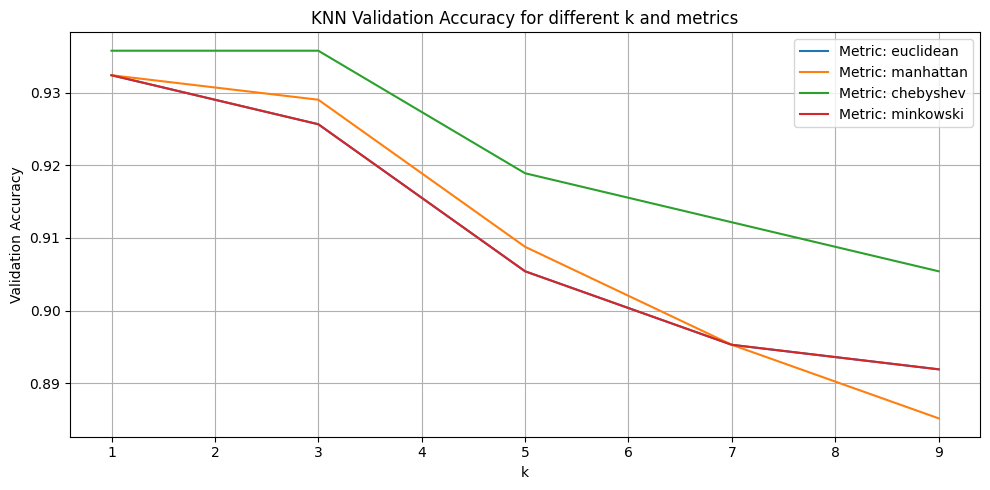

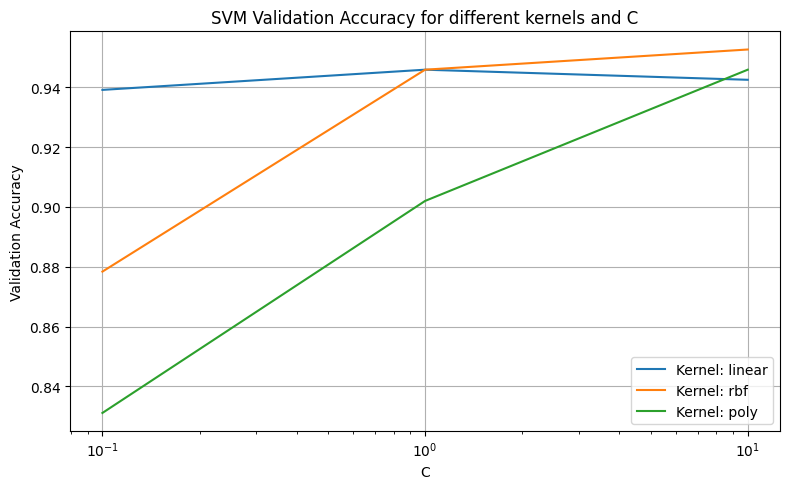

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from itertools import product
import matplotlib.pyplot as plt

def load_data(filename):
    df = pd.read_csv(filename)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

# Load the data
X_train, y_train = load_data('/home/teaching/Documents/assignment/assignment_1/face-nonface_modified/lbp_train.csv')
X_val, y_val = load_data('/home/teaching/Documents/assignment/assignment_1/face-nonface_modified/lbp_val.csv')
X_test, y_test = load_data('/home/teaching/Documents/assignment/assignment_1/face-nonface_modified/lbp_test.csv')

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# ---------------------- KNN Evaluation ---------------------- #
k_values = [1, 3, 5, 7, 9]
metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
knn_val_accuracies = []
best_knn_acc = 0
best_knn_params = None

for k, metric in product(k_values, metrics):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    knn_val_accuracies.append((k, metric, acc))
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_knn_params = (k, metric)

# Retrain KNN on train+val
X_trainval = np.vstack([X_train, X_val])
y_trainval = np.concatenate([y_train, y_val])
best_k, best_metric = best_knn_params
best_knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
best_knn.fit(X_trainval, y_trainval)
y_test_pred_knn = best_knn.predict(X_test)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)

print(f"Best KNN: k={best_k}, metric={best_metric}, Test Accuracy={test_acc_knn:.4f}")

# ---------------------- SVM Evaluation ---------------------- #
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]
svm_val_accuracies = []
best_svm_acc = 0
best_svm_params = None

for kernel, C in product(kernels, C_values):
    svm = OneVsRestClassifier(SVC(kernel=kernel, C=C))
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    svm_val_accuracies.append((kernel, C, acc))
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_svm_params = (kernel, C)

# Retrain best SVM on train+val
best_kernel, best_C = best_svm_params
best_svm = OneVsRestClassifier(SVC(kernel=best_kernel, C=best_C))
best_svm.fit(X_trainval, y_trainval)
y_test_pred_svm = best_svm.predict(X_test)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

print(f"Best One-vs-Rest SVM: kernel={best_kernel}, C={best_C}, Test Accuracy={test_acc_svm:.4f}")

# ---------------------- Plotting ---------------------- #
# KNN Plot
plt.figure(figsize=(10, 5))
for metric in metrics:
    accs = [acc for (k, m, acc) in knn_val_accuracies if m == metric]
    ks = [k for (k, m, acc) in knn_val_accuracies if m == metric]
    plt.plot(ks, accs, label=f'Metric: {metric}')
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title('KNN Validation Accuracy for different k and metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# SVM Plot
plt.figure(figsize=(8, 5))
for kernel in kernels:
    accs = [acc for (k, c, acc) in svm_val_accuracies if k == kernel]
    Cs = [c for (k, c, acc) in svm_val_accuracies if k == kernel]
    plt.plot(Cs, accs, label=f'Kernel: {kernel}')
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Validation Accuracy')
plt.title('SVM Validation Accuracy for different kernels and C')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Creating balanced dataset...
Processing 986 face images...
Processing 986 non-face images...

Dataset splits:
Train: 1380 samples
Val: 296 samples
Test: 296 samples

Performing grid search...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'svm__C': 100, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation accuracy: 0.8442

Validation accuracy: 0.8378

Test Set Performance:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       164
           1       0.81      0.83      0.82       132

    accuracy                           0.84       296
   macro avg       0.84      0.84      0.84       296
weighted avg       0.84      0.84      0.84       296



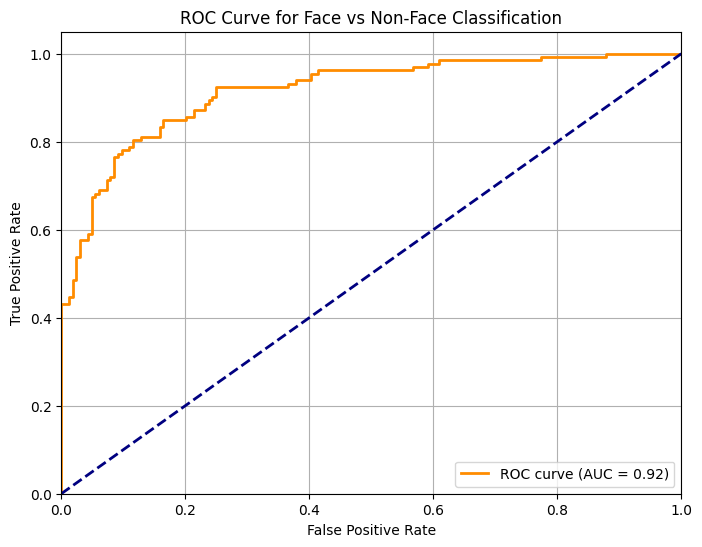

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.feature import local_binary_pattern

def get_lbp_features(image_path):
    try:
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")
        
        image = cv2.resize(image, (128, 128))
        
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        n_bins = n_points + 2
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        hist = hist.astype('float') / (hist.sum() + 1e-7)  
        return hist
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

def create_balanced_dataset(face_dir, non_face_dir, n_samples=None):
    """Create balanced dataset from face and non-face directories"""
    face_images = list(Path(face_dir).rglob("*.jpg"))
    non_face_images = list(Path(non_face_dir).rglob("*.jpg"))
    
    if n_samples is None:
        n_samples = min(len(face_images), len(non_face_images))
    
    face_images = np.random.choice(face_images, n_samples, replace=False)
    non_face_images = np.random.choice(non_face_images, n_samples, replace=False)
    
    features = []
    labels = []
    
    print(f"Processing {len(face_images)} face images...")
    for img_path in face_images:
        feat = get_lbp_features(img_path)
        if feat is not None:
            features.append(feat)
            labels.append(1)
    
    print(f"Processing {len(non_face_images)} non-face images...")
    for img_path in non_face_images:
        feat = get_lbp_features(img_path)
        if feat is not None:
            features.append(feat)
            labels.append(0)
    
    return np.array(features), np.array(labels)

np.random.seed(42)

base_path = "/home/teaching/Documents/assignment/assignment_1/face-nonface_modified"
face_dir = os.path.join(base_path, "face")
non_face_dir = os.path.join(base_path, "non-face")

print("Creating balanced dataset...")
X, y = create_balanced_dataset(face_dir, non_face_dir)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nDataset splits:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

param_grid = {
    'svm__kernel': ['rbf', 'linear'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto']
}

print("\nPerforming grid search...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

val_accuracy = grid_search.score(X_val, y_val)
print("\nValidation accuracy: {:.4f}".format(val_accuracy))

y_pred = grid_search.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Face vs Non-Face Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [8]:
train_accuracy = grid_search.score(X_train, y_train)
print("\nTraining accuracy: {:.4f}".format(train_accuracy))



Training accuracy: 0.9841


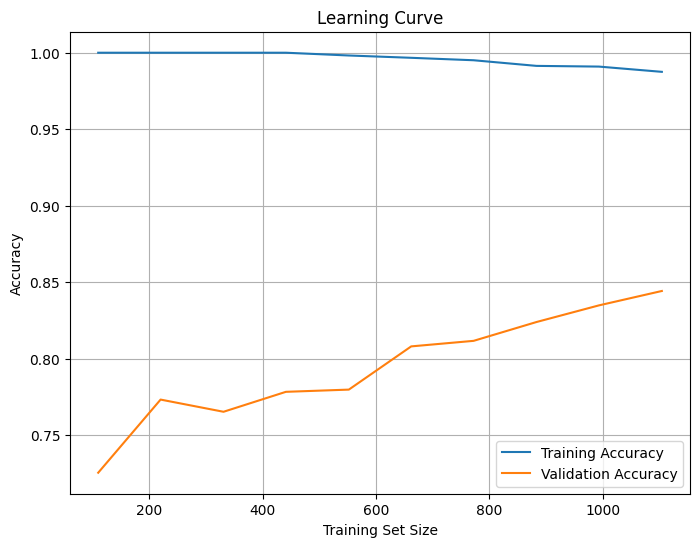

In [2]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Accuracy")
plt.plot(train_sizes, val_scores_mean, label="Validation Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib

best_model = grid_search.best_estimator_
joblib.dump(best_model, 'face_detector_model.pkl')
print("Model saved successfully!")

Model saved successfully!


**Testing the Model on a Image**

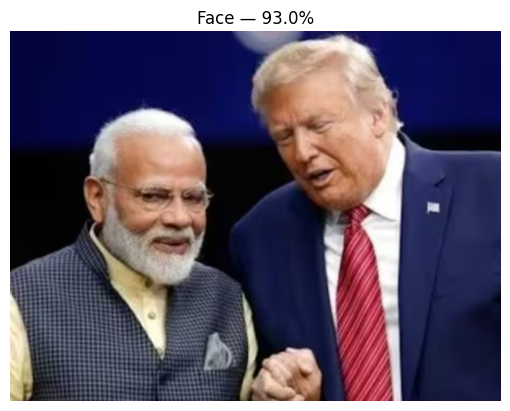

Prediction: Face (probability: 0.9300)


In [ ]:
import joblib

model = joblib.load("face_detector_model.pkl")

def get_lbp_features(image_path):
    """Extract LBP features from an image (same as used for training)."""
    image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")
    image = cv2.resize(image, (128, 128))
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    n_bins = n_points + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype('float') / (hist.sum() + 1e-7)
    return hist.reshape(1, -1)

def predict_face(image_path):
    features = get_lbp_features(image_path)
    prob = model.predict_proba(features)[0][1]
    label = "Face" if prob >= 0.5 else "Non-Face"
    rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.title(f"{label} — {prob*100:.1f}%")
    plt.axis('off')
    plt.show()
    print(f"Prediction: {label} (probability: {prob:.4f})")

predict_face("/home/teaching/Documents/assignment/assignment_1/image copy.png")

Total faces detected: 2


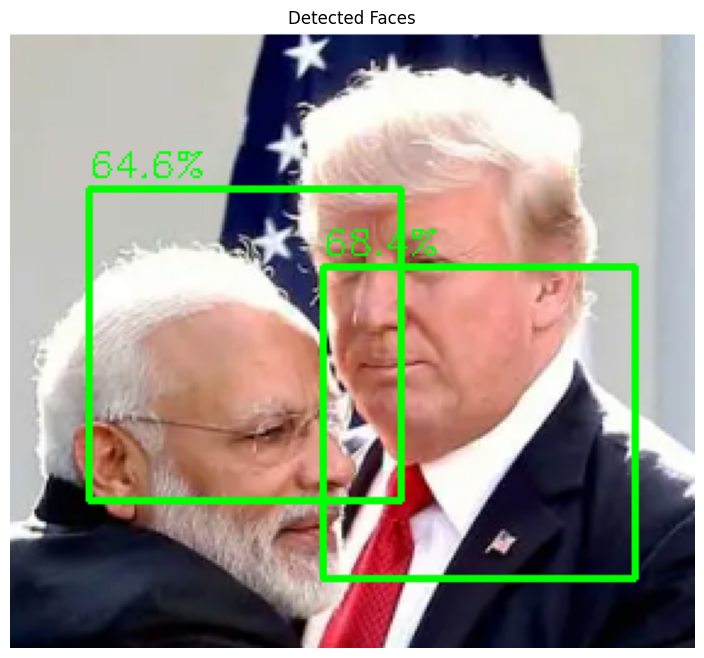

In [ ]:

model = joblib.load("face_detector_model.pkl")

def get_lbp_features_from_patch(gray_patch):
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_patch, n_points, radius, method='uniform')
    n_bins = n_points + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype('float') / (hist.sum() + 1e-7)
    return hist.reshape(1, -1)

def non_max_suppression(boxes, probs, overlapThresh=0.3):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    probs = np.array(probs)
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)[::-1]

    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[1:]]

        idxs = np.delete(
            idxs, np.concatenate(([0], np.where(overlap > overlapThresh)[0] + 1))
        )
    return boxes[pick], probs[pick]

def sliding_window_face_detection(image_path, window_size=(128,128), step_size=32, threshold=0.5):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image: {image_path}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    detections = []
    probs = []

    for y in range(0, h - window_size[1] + 1, step_size):
        for x in range(0, w - window_size[0] + 1, step_size):
            patch = gray[y:y+window_size[1], x:x+window_size[0]]
            features = get_lbp_features_from_patch(patch)
            prob = model.predict_proba(features)[0][1]
            if prob >= threshold:
                detections.append([x, y, x+window_size[0], y+window_size[1]])
                probs.append(prob)

    if detections:
        boxes, box_probs = non_max_suppression(detections, probs, overlapThresh=0.3)
        for (x1, y1, x2, y2), prob in zip(boxes, box_probs):
            cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(image, f"{prob*100:.1f}%", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
        print(f"Total faces detected: {len(boxes)}")
    else:
        print("No faces detected.")

    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Detected Faces")
    plt.show()

sliding_window_face_detection("/home/teaching/Documents/assignment/assignment_1/image copy.png")

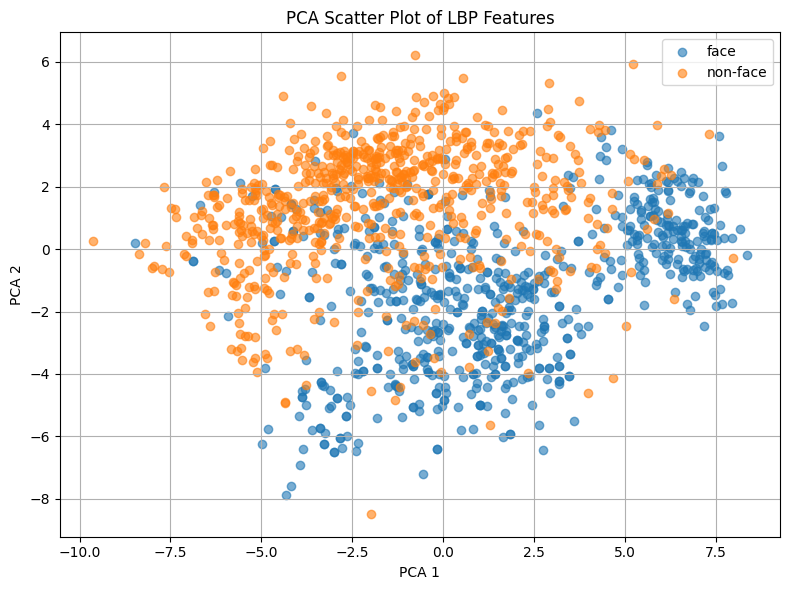

/home/teaching/miniconda3/envs/assign1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


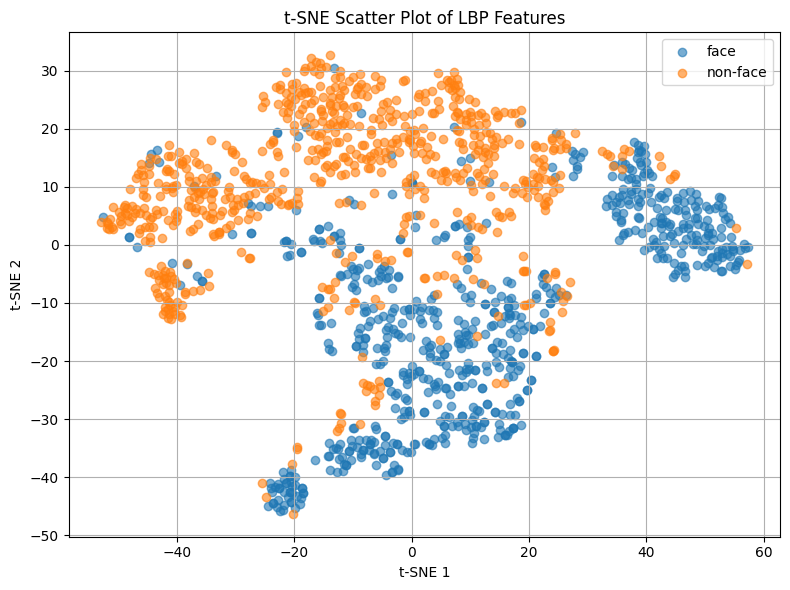

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Load data
def load_data(filename):
    df = pd.read_csv(filename)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

# Load and normalize
X_train, y_train = load_data('/home/teaching/Documents/assignment/assignment_1/face-nonface_modified/lbp_train.csv')
X_test, y_test = load_data('/home/teaching/Documents/assignment/assignment_1/face-nonface_modified/lbp_test.csv')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# =================== PCA ===================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=label, alpha=0.6)
plt.title('PCA Scatter Plot of LBP Features')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =================== t-SNE ===================
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label, alpha=0.6)
plt.title('t-SNE Scatter Plot of LBP Features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()